In [2]:
from torchvision import datasets
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torch import nn
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import scipy.sparse as sp
from tqdm import tqdm_notebook as tqdm
import torch
from IPython.display import HTML

In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [4]:
ROOT = './data'
n_dims = 25088

In [5]:
class CBIRDataset(Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.images = os.listdir(root)
        self.transforms = transforms

    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.root, self.images[idx]))
        img = self.transforms(img)
        return idx, img

    def __len__(self):
        return len(self.images)

In [6]:
transforms = T.Compose([
    T.Resize(size=(224, 224)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

dsetCBIR = CBIRDataset(ROOT, transforms)

In [7]:
dataloader = DataLoader(dsetCBIR, batch_size=64)

In [8]:
model = models.vgg16(pretrained=True)

C:\Users\Asus\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

In [10]:
model.classifier = Identity()

In [11]:
preds = sp.lil_matrix((len(dsetCBIR), n_dims))
preds.shape

(240, 25088)

In [12]:
model.to(device)
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [13]:
for i, img in tqdm(dataloader):
    pred = model(img.to(device))
    preds[i.min() : i.max() + 1, :] = pred.cpu().detach()

C:\Users\Asus\AppData\Local\Temp\ipykernel_6076\1944769147.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, img in tqdm(dataloader):


  0%|          | 0/4 [00:00<?, ?it/s]

In [14]:
def cosine_similarity(ratings):
    sim = ratings.dot(ratings.T)
    if not isinstance(sim, np.ndarray):
        sim = sim.toarray()
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return (sim / norms / norms.T)

In [15]:
preds = preds.tocsr()
sim = cosine_similarity(preds)

In [16]:
def get_thumbnails(sim, idx, N=10):
    row = sim[idx, :]
    thumbs = []
    files = os.listdir(ROOT)

    for x in np.argsort(-row)[:N]:

        thumbs.append(files[x])
    
    return thumbs

In [17]:
def display_thumbs(thumbs, N=9):

    display(HTML(''+'Query Image'+''))

    fig, ax = plt.subplots(figsize=(3,3))
    ax.axis('off')
    ax.imshow(Image.open(os.path.join(ROOT, thumbs[0])))
    plt.show()

    display(HTML(''+'Retrieved Images'+''))


    fig = plt.figure(figsize=(10, 10))

    for i, img in enumerate(thumbs[1:N+1]):
        image = Image.open(os.path.join(ROOT, img))
        fig.add_subplot(3, 3, i+1)
        plt.axis('off')
        plt.imshow(image)

    plt.show()

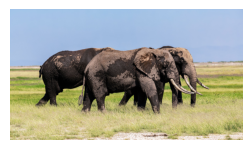

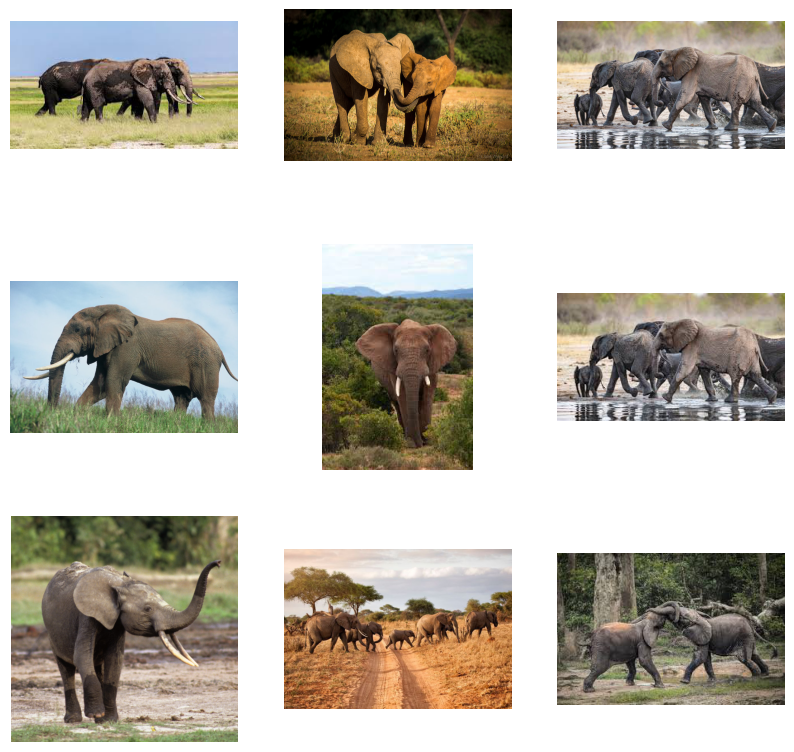

In [20]:
display_thumbs(get_thumbnails(sim, 40, N=10))